In [1]:
import pandas as pd
import collections
import timeit
from scipy.integrate import odeint
import matplotlib.pyplot as plt
import networkx as nx
import matplotlib.mlab as mlab
import statistics
import random
import numpy.linalg
import numpy as np
import sys
from scipy.optimize import minimize
elapsed_time = timeit.default_timer()
from sklearn.linear_model import LinearRegression
from sklearn import cluster
import seaborn as sns
sns.set()
from sklearn import datasets
from sklearn.metrics import r2_score
from matplotlib import pylab
from matplotlib import font_manager
import multiprocessing
from multiprocessing import Pool
import itertools
%matplotlib inline

In [2]:
def get_reactors(reac):
    reac_split = reac.split(' ')
    reactors = []
    for k in reac_split:
        if k != '&' and k!= '=>':
            reactors.append(k)
    return reactors[:-1]


def Hill(reactor, n, EC50):
    B = (EC50**n-1)/(2*EC50**n-1)
    C = (B-1)**(1/n)
    if reactor[0] == '!':
        m = max(globals()['{}'.format(reactor[1:])], 0)
        return (1-B*m**n/(C**n + m**n))
    else:
        m = max(globals()['{}'.format(reactor)], 0)
        return B*m**n/(C**n + m**n)
    
# def Hill(reactor, n, EC50):
#     B = (EC50**n-1)/(2*EC50**n-1)
#     C = (B-1)**(1/n)
#     if reactor[0] == '!':
#         return (1-B*globals()['{}'.format(reactor[1:])]**n/(C**n + globals()['{}'.format(reactor[1:])]**n))
#     else:
#         return B*globals()['{}'.format(reactor)]**n/(C**n + globals()['{}'.format(reactor)]**n)



def OR(reaction_list):
    tera = (-1)**(len(reaction_list)+1)
    for k in reaction_list:
        weight, n, EC50 = reaction_list[k]
        final = weight
        for j in get_reactors(k):
            final *= Hill(j, n, EC50)
        tera *= (final-1)
    tera +=1
    return tera

In [3]:
def inte(state, t, reaction_dict):
    for i in range(len(node_ID)):
        globals()['{}'.format(node_ID[i])] = state[i]
    for i in range(len(node_ID)):
        if len(reaction_dict[node_ID[i]]) == 1:
            reactors = get_reactors(list(reaction_dict[node_ID[i]].keys())[0])
            weight, n, EC50 = reaction_dict[node_ID[i]][list(reaction_dict[node_ID[i]].keys())[0]]
            TF = 1
            for j in reactors:
                TF *= Hill(j, n, EC50)
            globals()['{}'.format(node_ID[i] + 'd')] = (TF*weight*Ymax[i]-globals()['{}'.format(node_ID[i])])/tau[i]
        else:
            TF = OR(reaction_dict[node_ID[i]])
            globals()['{}'.format(node_ID[i] + 'd')] = (TF*Ymax[i]-globals()['{}'.format(node_ID[i])])/tau[i]
    return [globals()['{}'.format(k+ 'd')] for k in node_ID]

In [18]:
reactions_raw = pd.read_excel('PAFModel_split_final_v3.xlsx', sheet_name = 1, skiprows = 1, header = 0)
species_raw = pd.read_excel('PAFModel_split_final_v3.xlsx', sheet_name = 0, skiprows = 1, header = 0)

In [19]:
species = species_raw[['ID', 'Yinit', 'Ymax', 'tau']]
node_ID = species['ID'].tolist()
Yinit = species['Yinit'].tolist()
Ymax = species['Ymax'].tolist()
tau = species['tau'].tolist()

In [20]:
species_dict = dict()
for k in range(len(species)):
    #lis = species.loc[k, ['Yinit', 'Ymax', 'tau']].tolist()
    species_dict[species.loc[k, 'ID']] = species.loc[k, ['Yinit', 'Ymax', 'tau']].tolist()

state0 = []
for k in range(len(node_ID)):
    state0.append(Yinit[k])

In [21]:
reactions = {
    'rule':reactions_raw['Rule'].tolist(), 
    'weight':reactions_raw['Weight'].tolist(), 
    'n':reactions_raw['n'].tolist(), 
    'EC50':reactions_raw['EC50'].tolist()
}
reactions = pd.DataFrame(data = reactions)
reaction_dict = collections.defaultdict(dict)
for k in range(len(reactions)):
    node = reactions.loc[k, 'rule'].split(' ')
    reaction_dict[node[-1]][reactions.loc[k, 'rule']] = reactions.loc[k, ['weight', 'n', 'EC50']].tolist() 

In [22]:
result = 0
total = 0
t = np.arange(0.0, 60.0*24, 0.1)
simu_data = odeint(inte, state0, t, args = (reaction_dict, ))

In [23]:
gene_set = ['aSMAmRNA', 'fibmRNA', 'CImRNA', 'CIIImRNA', 'LOXmRNA', 'elastinmRNA']

In [24]:
validation = [
    {'input': {'stretch': 0.7, 'stiffness': 0.25}, 'results': [1,0,1,1,1,1]},
    {'input': {'stretch': 0.25, 'stiffness': 0.7}, 'results': [1,1,1,1,1,1]},
    {'input': {'stretch': 0.7, 'stiffness': 0.7}, 'results': [1,1,1,1,1,1]}
]

In [25]:
val = validation[0]
reaction_dict['stretch']['=> stretch'][0] = 0.7 #val['input']['stretch']
reaction_dict['stiffness']['=> stiffness'][0] = 0.25 #val['input']['stiffness']

In [26]:
new_data = odeint(inte, state0, t, args = (reaction_dict, ))
for each in range(len(gene_set)):
    total += 1
    ind = node_ID.index(gene_set[each])
    if abs(new_data[-1, ind] - simu_data[-1, ind]) < 0.05 and val['results'][each] == 0:
        result += 1
        print(gene_set[each])
    elif new_data[-1, ind] - simu_data[-1, ind] >= 0.05 and val['results'][each] == 1:
        result += 1
        print(gene_set[each])

aSMAmRNA
fibmRNA
CImRNA
CIIImRNA
LOXmRNA
elastinmRNA


In [30]:
reaction_dict['stretch']['=> stretch'][0] = 0.25 #val['input']['stretch']
reaction_dict['stiffness']['=> stiffness'][0] = 0.9 #val['input']['stiffness']
new_data = odeint(inte, state0, t, args = (reaction_dict, ))
for i in gene_set:
    print(i, new_data[-1, node_ID.index(i)], simu_data[-1, node_ID.index(i)])
reaction_dict['stretch']['=> stretch'][0] = 0.25
reaction_dict['stiffness']['=> stiffness'][0] = 0.25

aSMAmRNA 0.9995800876772281 0.2074244259535904
fibmRNA 0.9677036602962507 0.02047667036624688
CImRNA 0.999766511348223 0.09544987204040406
CIIImRNA 0.999766511348223 0.09544987204040406
LOXmRNA 0.91080816257053 0.004057539623179771
elastinmRNA 0.9997286779260266 0.3487474410088779


In [33]:
reaction_dict['stretch']['=> stretch'][0] = 0.25 #val['input']['stretch']
reaction_dict['stiffness']['=> stiffness'][0] = 0.9 #val['input']['stiffness']
new_data = odeint(inte, state0, t, args = (reaction_dict, ))
for i in gene_set:
    print(i, new_data[-1, node_ID.index(i)], simu_data[-1, node_ID.index(i)])
reaction_dict['stretch']['=> stretch'][0] = 0.25
reaction_dict['stiffness']['=> stiffness'][0] = 0.25

aSMAmRNA 1.0 0.3051018117912602
fibmRNA 1.0000000000000004 0.09045635921272627
CImRNA 1.0 0.10953904674701133
CIIImRNA 1.0 0.10953904674701133
LOXmRNA 0.9108081625742391 0.004057539623213023
elastinmRNA 1.0 0.8671041859042781


In [15]:
### Stiffness
reaction_dict['stretch']['=> stretch'][0] = 0.25 #val['input']['stretch']
reaction_dict['stiffness']['=> stiffness'][0] = 0.7 #val['input']['stiffness']
new_data_stiff = odeint(inte, state0, t, args = (reaction_dict, ))

In [17]:
reaction_dict['stretch']['=> stretch'][0] = 0.25 #val['input']['stretch']
reaction_dict['stiffness']['=> stiffness'][0] = 0.5 #val['input']['stiffness']
new_data_stiff_05 = odeint(inte, state0, t, args = (reaction_dict, ))

In [18]:
for i in gene_set:
    print(i, new_data_stiff[-1, node_ID.index(i)], new_data_stiff_05[-1, node_ID.index(i)], simu_data[-1, node_ID.index(i)])

aSMAmRNA 0.8153537237740632 0.39417531796769795 0.1843143862785706
fibmRNA 0.38721558992443444 0.06443882836832689 0.008786498727480895
CImRNA 0.8342046855641327 0.35383853242686686 0.09542702354558442
CIIImRNA 0.8342046855641327 0.35383853242686686 0.09542702354558442
LOXmRNA 0.36887717994382013 0.07323618418293029 0.004057539623184128
elastinmRNA 0.8712863205605864 0.49068242436868537 0.21156795223992605


In [108]:
# inhibit ERK1_2 and check fibmRNA
reaction_dict['stretch']['=> stretch'][0] = 0.25 #val['input']['stretch']
reaction_dict['stiffness']['=> stiffness'][0] = 0.7 #val['input']['stiffness']
inhi_data_0 = odeint(inte, simu_data[-1,:], t, args = (reaction_dict, ))
Ymax[node_ID.index('AT1R')] = 0
reaction_dict['stretch']['=> stretch'][0] = 0.25 #val['input']['stretch']
reaction_dict['stiffness']['=> stiffness'][0] = 0.7 #val['input']['stiffness']
inhi_data_1 = odeint(inte, simu_data[-1,:], t, args = (reaction_dict, ))
Ymax[node_ID.index('AT1R')] = 1
reaction_dict['stretch']['=> stretch'][0] = 0.25 #val['input']['stretch']
reaction_dict['stiffness']['=> stiffness'][0] = 0.25 #val['input']['stiffness']

In [109]:
for i in gene_set:
    print(i, 
          inhi_data_1[-1,node_ID.index(i)], 
          inhi_data_0[-1,node_ID.index(i)],
          inhi_data_1[-1,node_ID.index(i)] - inhi_data_0[-1,node_ID.index(i)]
    )

aSMAmRNA 0.6664228726490116 0.8274630132962674 -0.1610401406472558
fibmRNA 0.24111930244845228 0.4177354951353813 -0.176616192686929
CImRNA 0.6490835387180411 0.8358297916527058 -0.18674625293466462
CIIImRNA 0.6490835387180411 0.8358297916527058 -0.18674625293466462
LOXmRNA 0.36887717994341945 0.36887718005132364 -1.0790418558670467e-10
elastinmRNA 0.7846077077055873 0.8847840998604697 -0.10017639215488239


In [85]:
reaction_dict['elastinmRNA']['!JNK1_2 => elastinmRNA'][0] = 0.25

In [84]:
Ymax[node_ID.index('AT1R')] = 1

In [82]:
# inhibit ERK1_2 and check fibmRNA
Ymax[node_ID.index('AT1R')] = 0
reaction_dict['stretch']['=> stretch'][0] = 0.25 #val['input']['stretch']
reaction_dict['stiffness']['=> stiffness'][0] = 0.25 #val['input']['stiffness']
inhi_data_0 = odeint(inte, state0, t, args = (reaction_dict, ))
reaction_dict['stretch']['=> stretch'][0] = 0.7 #val['input']['stretch']
reaction_dict['stiffness']['=> stiffness'][0] = 0.25 #val['input']['stiffness']
inhi_data_1 = odeint(inte, state0, t, args = (reaction_dict, ))
Ymax[node_ID.index('AT1R')] = 1

In [83]:
for each in range(len(gene_set)):
    ind = node_ID.index(gene_set[each])
    print(gene_set[each], inhi_data_1[-1, ind], inhi_data_0[-1, ind], inhi_data_1[-1, ind] - inhi_data_0[-1, ind])

aSMAmRNA 0.20605675570751147 0.20605675570751097 4.996003610813204e-16
fibmRNA 0.02019461723180295 0.02019461723180293 2.0816681711721685e-17
CImRNA 0.41463839708108524 0.07627096264857465 0.3383674344325106
CIIImRNA 0.41463839708108524 0.07627096264857465 0.3383674344325106
LOXmRNA 0.3688771799436368 0.004057539623183182 0.3648196403204536
elastinmRNA 0.3638587992672011 0.36385879926720094 1.6653345369377348e-16


In [15]:
for each in range(len(gene_set)):
    ind = node_ID.index(gene_set[each])
    print(gene_set[each], new_data[-1, ind], simu_data[-1, ind], new_data[-1, ind] - simu_data[-1, ind])

aSMAmRNA 0.10824301073936947 0.10824258951952573 4.2121984374088317e-07
fibmRNA 9.998932775185369e-05 9.999747324066353e-05 -8.145488809846316e-09
CImRNA 0.09654841469700748 0.09654798980555812 4.24891449357645e-07
CIIImRNA 0.09654841469700748 0.09654798980555812 4.24891449357645e-07
LOXmRNA 0.026589950562745046 0.026589800312396217 1.502503488293172e-07
elastinmRNA 0.2093628525738699 0.20936219756947308 6.550043968323038e-07


In [19]:
new_data[-1, node_ID.index('fibmRNA')]

0.02325566870445391

In [20]:
simu_data[-1, node_ID.index('fibmRNA')]

0.008786498727480614

In [158]:
valid = dict() ## {}
valid['TGFB'] = {
    'aSMA': 1,
    'proliferation': 1,
    'migration': 1,
    'CI': 1,
    'CIII': 1,
    'clOPN': 0,
    'fibronectin': 0,
    'p38': 1,
    'ERK1_2': 1,
    'elastin': 1
}


valid['AngII'] = {
    'migration': 1,
    'proliferation': 1,
    'CI': 1,
    'Nox4': -1,
    'ET1': 1
}


"""valid['mechanical'] = {
    'aSMA': -1,
    'proliferation': 1,
    'MMP2': 1,
    'MMP9': 0,
    'miR130_301': 1
}"""


valid['TNFa'] = {
    'IL6': 1,
    'ROS': 1,
    'Akt': 0
}

valid['hypoxia'] = {
    'Nox4': 1,
    'proliferation': 1,
    'ROS': 1,
    'CI': 1,
    'fibronectin': 1,
    'LOX': 1,
    'MMP2': 1,
    'aSMA': 0,
    'HIF1a': 1
}

valid['FGF'] = {
    'aSMA': 1,
    'proliferation': 1,
    'TGFB': 1
}

valid['PDGF'] = {
    'migration': 1,
    'MMP2': 1,
    'TIMP1': -1,
    'CI': 1
}

In [159]:
reaction_dict['stretch']['=> stretch'][0] = 0.25
reaction_dict['stiffness']['=> stiffness'][0] = 0.25
val_res = 0
val_tot = 0
for i in valid:
    reaction_dict[i]['=> '+i][0] = 0.7 #val['input']['stretch']
    new_d = odeint(inte, state0, t, args = (reaction_dict, ))
    for j in valid[i]:
        ind = node_ID.index(j)
        if abs(new_d[-1, ind] - simu_data[-1, ind]) < 0.05 and valid[i][j] == 0:
            print(i,j,'equal')
            val_res += 1
        elif new_d[-1, ind] - simu_data[-1, ind] >= 0.05 and valid[i][j] == 1:
            print(i,j,'big')
            val_res += 1
        elif new_d[-1, ind] - simu_data[-1, ind] <= -0.05 and valid[i][j] == -1:
            print(i,j,'small')
            val_res += 1
        val_tot += 1
    reaction_dict[i]['=> '+i][0] = 0.25
print(val_res/val_tot)

TGFB aSMA big
TGFB proliferation big
TGFB migration big
TGFB CI big
TGFB CIII big
TGFB clOPN equal
TGFB p38 big
TGFB elastin big
AngII migration big
AngII proliferation big
AngII CI big
AngII ET1 big
TNFa IL6 big
TNFa ROS big
TNFa Akt equal
hypoxia Nox4 big
hypoxia proliferation big
hypoxia ROS big
hypoxia CI big
hypoxia fibronectin big
hypoxia MMP2 big
hypoxia HIF1a big
FGF aSMA big
FGF proliferation big
FGF TGFB big
PDGF migration big
PDGF MMP2 big
PDGF TIMP1 small
0.8235294117647058


In [65]:
reaction_dict['AngII']['=> '+'AngII'][0] = 0.7 
new_d = odeint(inte, state0, t, args = (reaction_dict, ))
reaction_dict['AngII']['=> '+'AngII'][0] = 0.25 
for i in valid['AngII']:
    print(
        i,
        new_d[-1, node_ID.index(i)],
        simu_data[-1, node_ID.index(i)]
    )

migration 0.7455566343228395 0.4064418827653384
proliferation 0.48932834263481734 0.12857436948637588
CI 0.3396245240078694 0.07091980972885778
Nox4 0.21069175159689768 0.2106917515967806


aSMA 0.7270555645788085 0.09747339792890355
proliferation 0.7166761493771384 0.1285743694863738
migration 0.9057482832807431 0.40644188276530924
CI 0.7032049233716561 0.11054304249685055
CIII 0.7032049233716561 0.11054304249685055
clOPN 0.15452526915866113 0.15452526915866116
fibronectin 0.2407416154383924 0.0013811069090189614
p38 0.5667777801511601 0.0728609885366138
ERK1_2 0.6550154873370723 0.3385081160402905
elastin 0.4256626598247412 0.7436322904767856


In [128]:
simu_data[-1, node_ID.index('TGFB')]

0.3618635655691112

In [42]:
def get_relation(reac):
    split_reac = reac.split(' ')
    if len(split_reac) ==2:
        return ['Input', split_reac[1]]
    else:
        reactor = []
        for k in split_reac[:-2]:
            if k!= '&':
                reactor.append(getout_inhib(k))
        return [reactor, split_reac[-1]]
def getout_inhib(node):
    if node[0] == '!':
        return node[1:]
    else:
        return node
    
rules = reactions['rule'].tolist()
relationship = []
relationship_network = []
for k in rules:
    if get_relation(k)[0] == 'Input':
        relationship.append(tuple(get_relation(k)+[node_ID.index(get_relation(k)[1])]))
        relationship_network.append(tuple(get_relation(k)))
    else:
        for i in get_relation(k)[0]:
            relationship.append((i, get_relation(k)[1], node_ID.index(get_relation(k)[1])))
            relationship_network.append((i, get_relation(k)[1]))
            
xxx = pd.DataFrame(columns = ['Start', 'End', 'End_Index'])
for i in relationship:
    xxx.loc[len(xxx)] = list(i)

In [43]:
NetworkA = nx.DiGraph()
NetworkA.add_nodes_from(node_ID)
NetworkA.add_edges_from(relationship_network)

In [44]:
paths_between_generator_fibmrna = nx.all_simple_paths(NetworkA, source = 'stretch', target = 'aSMAmRNA')

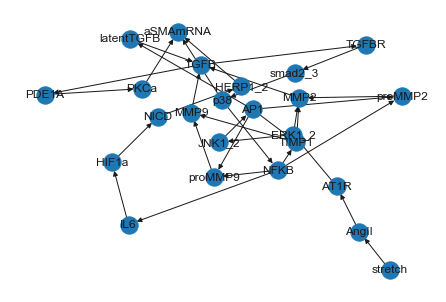

In [45]:
nodes_between_set_fibmrna = {node for path in paths_between_generator_fibmrna for node in path}
SG_fibmrna = NetworkA.subgraph(nodes_between_set_fibmrna)
nx.draw(SG_fibmrna,  pos=nx.spring_layout(SG_fibmrna), with_labels=True)
plt.show()

In [20]:
import json

In [21]:
nodes = [{'name': str(i)} for i in SG_fibmrna.nodes()]
links = [{'source': u[0], 'target': u[1]}
         for u in SG_fibmrna.edges()]
with open('graph.json', 'w') as f:
    json.dump({'nodes': nodes, 'links': links},
              f, indent=4,)

In [22]:
%%html
<div id="d3-example"></div>
<style>
.node {stroke: #fff; stroke-width: 1.5px;}
.link {stroke: #999; stroke-opacity: .6;}
</style>

In [23]:
%%javascript
// We load the d3.js library from the Web.
require.config({paths:
    {d3: "http://d3js.org/d3.v3.min"}});
require(["d3"], function(d3) {
  // The code in this block is executed when the
  // d3.js library has been loaded.

  // First, we specify the size of the canvas
  // containing the visualization (size of the
  // <div> element).
  var width = 300, height = 300;

  // We create a color scale.
  var color = d3.scale.category10();

  // We create a force-directed dynamic graph layout.
  var force = d3.layout.force()
    .charge(-120)
    .linkDistance(30)
    .size([width, height]);

  // In the <div> element, we create a <svg> graphic
  // that will contain our interactive visualization.
  var svg = d3.select("#d3-example").select("svg")
  if (svg.empty()) {
    svg = d3.select("#d3-example").append("svg")
          .attr("width", width)
          .attr("height", height);
  }

  // We load the JSON file.
  d3.json("graph.json", function(error, graph) {
    // In this block, the file has been loaded
    // and the 'graph' object contains our graph.

    // We load the nodes and links in the
    // force-directed graph.
    force.nodes(graph.nodes)
      .links(graph.links)
      .start();

    // We create a <line> SVG element for each link
    // in the graph.
    var link = svg.selectAll(".link")
      .data(graph.links)
      .enter().append("line")
      .attr("class", "link");

    // We create a <circle> SVG element for each node
    // in the graph, and we specify a few attributes.
    var node = svg.selectAll(".node")
      .data(graph.nodes)
      .enter().append("circle")
      .attr("class", "node")
      .attr("r", 5)  // radius
      .style("fill", function(d) {
         // The node color depends on the club.
         return color(d.club);
      })
      .call(force.drag);

    // The name of each node is the node number.
    node.append("title")
        .text(function(d) { return d.name; });

    // We bind the positions of the SVG elements
    // to the positions of the dynamic force-directed
    // graph, at each time step.
    force.on("tick", function() {
      link.attr("x1", function(d){return d.source.x})
          .attr("y1", function(d){return d.source.y})
          .attr("x2", function(d){return d.target.x})
          .attr("y2", function(d){return d.target.y});

      node.attr("cx", function(d){return d.x})
          .attr("cy", function(d){return d.y});
    });
  });
});

<IPython.core.display.Javascript object>

In [24]:
count = 0
total = 0
for a in list(nx.all_simple_paths(NetworkA, source = 'stretch', target = 'elastinmRNA')):
    if 'B3int' in a or 'MST1_2' in a:
        count += 1
    total += 1
print(count/total)

0.0


In [27]:
len(list(nx.all_simple_paths(NetworkA, source = 'stretch', target = 'elastinmRNA')))

45

In [25]:
for i in list(nx.all_simple_paths(NetworkA, source = 'stretch', target = 'elastinmRNA')):
    print(i)

['stretch', 'AngII', 'AT1R', 'ERK1_2', 'MMP2', 'TGFB', 'PDE1A', 'PKCa', 'elastinmRNA']
['stretch', 'AngII', 'AT1R', 'ERK1_2', 'MMP2', 'TGFB', 'TGFBR', 'elastinmRNA']
['stretch', 'AngII', 'AT1R', 'ERK1_2', 'JNK1_2', 'AP1', 'TIMP1', 'MMP9', 'TGFB', 'PDE1A', 'PKCa', 'elastinmRNA']
['stretch', 'AngII', 'AT1R', 'ERK1_2', 'JNK1_2', 'AP1', 'TIMP1', 'MMP9', 'TGFB', 'TGFBR', 'elastinmRNA']
['stretch', 'AngII', 'AT1R', 'ERK1_2', 'JNK1_2', 'AP1', 'TIMP1', 'MMP2', 'TGFB', 'PDE1A', 'PKCa', 'elastinmRNA']
['stretch', 'AngII', 'AT1R', 'ERK1_2', 'JNK1_2', 'AP1', 'TIMP1', 'MMP2', 'TGFB', 'TGFBR', 'elastinmRNA']
['stretch', 'AngII', 'AT1R', 'ERK1_2', 'JNK1_2', 'AP1', 'proMMP2', 'MMP2', 'TGFB', 'PDE1A', 'PKCa', 'elastinmRNA']
['stretch', 'AngII', 'AT1R', 'ERK1_2', 'JNK1_2', 'AP1', 'proMMP2', 'MMP2', 'TGFB', 'TGFBR', 'elastinmRNA']
['stretch', 'AngII', 'AT1R', 'ERK1_2', 'JNK1_2', 'AP1', 'proMMP9', 'MMP9', 'TGFB', 'PDE1A', 'PKCa', 'elastinmRNA']
['stretch', 'AngII', 'AT1R', 'ERK1_2', 'JNK1_2', 'AP1', 'proM

In [33]:
for i in list(nx.all_simple_paths(NetworkA, source = 'stretch', target = 'fibmRNA')):
    print(i)

['stretch', 'syndecan4', 'calcineurin', 'NFAT', 'clOPN', 'ERK1_2', 'p38', 'NFKB', 'fibmRNA']
['stretch', 'AngII', 'AT1R', 'ERK1_2', 'p38', 'NFKB', 'fibmRNA']
['stretch', 'TGFB', 'TGFBR', 'smad2_3', 'ERK1_2', 'p38', 'NFKB', 'fibmRNA']


In [39]:
aa = sum(map(lambda x : 1 if x == 1 else 0, correct))

In [41]:
correct_2nd = []
for i in range(len(lst)):
    changed = []
    for j in range(10):
        if lst[i][j]==0:
            m = uncertains[j].split(' => ')
            del reaction_dict[m[1]][uncertains[j]]
            changed.append([uncertains[j], m[1]])
    t = np.arange(0.0, 60.0*24, 0.1)
    reaction_dict['stretch']['=> stretch'][0] = 0.7
    reaction_dict['stiffness']['=> stiffness'][0] = 0.7
    simu_data = odeint(inte, state0, t, args = (reaction_dict, ))
    reaction_dict['stiffness']['=> stiffness'][0] = 0.9
    new_data = odeint(inte, state0, t, args = (reaction_dict, ))
    result = 0
    for each in gene_set:
        ind = node_ID.index(each)
        if each == 'aSMAmRNA' or each == 'LOXmRNA':
            if simu_data[-1, ind] - new_data[-1, ind] >= 0.05:
                result += 1
        else:
            if new_data[-1, ind] - simu_data[-1, ind] >= 0.05:
                result += 1
    correct_2nd.append(result/6)
    for m in changed:
        reaction_dict[m[1]][m[0]] = [1.0, 1.4, 0.6]
    reaction_dict['stretch']['=> stretch'][0] = 0.25
    reaction_dict['stiffness']['=> stiffness'][0] = 0.25

/Users/shulincao/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in double_scalars
  app.launch_new_instance()


In [42]:
len(correct_2nd)

1024

In [46]:
aa

0

In [ ]:
t = np.arange(0.0, 60.0*24, 0.1)
simu_data = odeint(inte, state0, t, args = (reaction_dict, ))

In [14]:
reaction_dict['stretch']['=> stretch'][0] = 0.7
new_data = odeint(inte, state0, t, args = (reaction_dict, ))

In [15]:
reaction_dict['stretch']['=> stretch'][0] = 0.5
new_data_05 = odeint(inte, state0, t, args = (reaction_dict, ))

In [16]:
reaction_dict['stretch']['=> stretch'][0] = 0.9
new_data_09 = odeint(inte, state0, t, args = (reaction_dict, ))

In [18]:
for each in gene_set:
    ind = node_ID.index(each)
    print(each, new_data[-1, ind] - simu_data[-1, ind])

aSMAmRNA 0.606383553220193
fibmRNA 0.8725947291672199
CImRNA 0.8071580115464344
CIIImRNA 0.8071580115464344
LOXmRNA 0.36481964032054814
elastinmRNA 0.1421817179916638


In [19]:
reaction_dict['stretch']

{'=> stretch': [0.9, 1.4, 0.6]}

In [ ]:
nodes = ['B3int', 'syndecan4', 'MST1_2', 'AngII', 'TGFB']